<a href="https://colab.research.google.com/github/MartinBergerJena/repo1/blob/main/run_matsim_iserlohn_g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Zelle 0: Workshop-Daten herunterladen  
Diese Zelle lädt die Daten runter und installiert MATsim und alles weitere benötigte.

Die Daten für das Iserlohn Model stammen von Senozon und sind mit der CC NC Lizenz belegt. Damit sind sie nicht für Kommerzielle Nutzung vorgesehen.

Senozon Mobilitätsmodell Deutschland, Release 2025Q1-00, Mittlerer Werktag, Senozon Deutschland GmbH, 2025

- **Wann ausführen?** Nur einmal zu Beginn, um den `data/`-Ordner zu erzeugen.

In [1]:
print("Java installation gestartet...")
!apt-get update -qq >/dev/null 2>&1
!apt-get install -y openjdk-21-jre-headless -qq >/dev/null 2>&1
print("Java installiert")
!wget -q https://syncandshare.lrz.de/dl/fiBFkbP1PAY7SLAhQbhfD5/matsim-2025.0-release.zip
!wget -q https://syncandshare.lrz.de/dl/fiEwNdWnokwgNjmtVg6Rv7/Senozon_Iserlohn.zip
!wget -q https://syncandshare.lrz.de/dl/fi9CAjy1GwB61yXfkHCzWA/custom_code.zip
print("Daten heruntergeladen")
!unzip -qq Senozon_Iserlohn.zip -d data >/dev/null 2>&1
!unzip -qq custom_code.zip >/dev/null 2>&1
print("Daten entpackt")
!unzip -qq matsim-2025.0-release.zip >/dev/null 2>&1
print("MATsim installiert")
!pip install matsim-tools contextily >/dev/null 2>&1
print("Bibliotheken installiert")

Java installation gestartet...
Java installiert
Daten heruntergeladen
Daten entpackt
MATsim installiert
Bibliotheken installiert


### Zelle 1: Netzwerk visualisieren  
Diese Zelle zeigt das Straßennetz zweimal: einmal komplett und einmal als Zoom-Ausschnitt.  
- **Parameter anpassen:**  
  - `xlim`, `ylim`: Koordinatenbereich für den Zoom – hier auf die Innenstadt begrenzt.  
- **Was du siehst:** Dunkelblaue Linien sind Straßen; der Kartenhintergrund kommt von OpenStreetMap. So bekommst du ein Gefühl für Lage und Größe des Netzes.

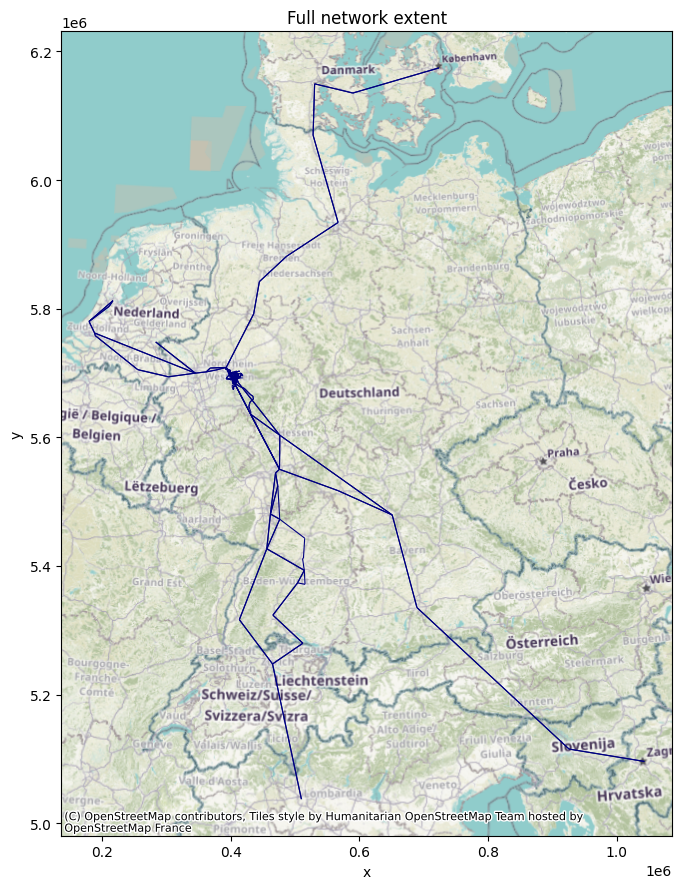

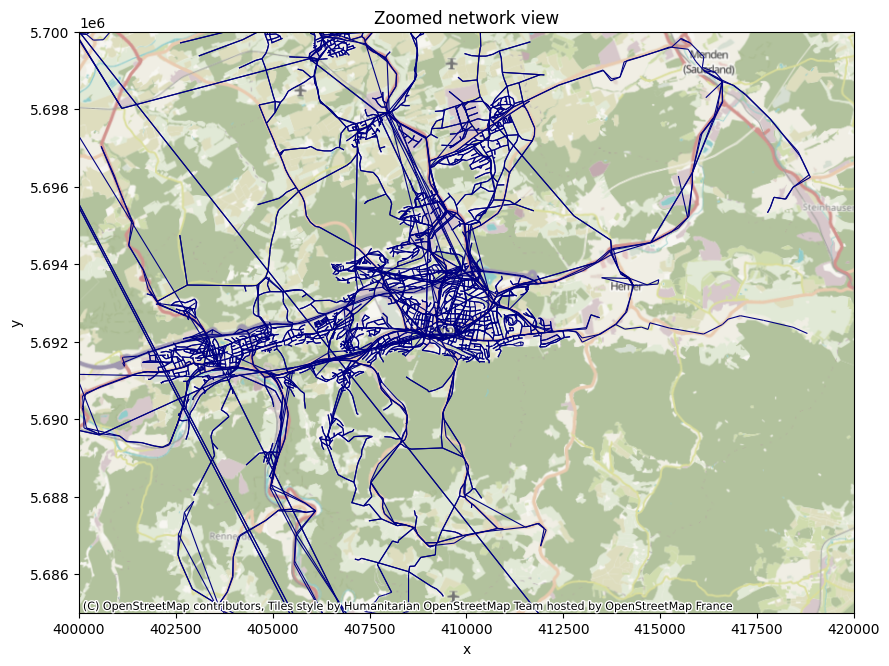

In [2]:
from matsim_helpers import plot_network_dual

plot_network_dual(
    "data/network.xml.gz",
    xlim=(0.40e6, 0.42e6),
    ylim=(5.685e6, 5.700e6)
)

### Zelle 2: Bevölkerung wählen & Personen-Attribute erkunden  

Mit dem Schalter **`local_population`** bestimmst du, welche Personen-Datei geladen wird:  
* **True** → `populationATA.xml.gz`  
  *Einwohnende von Iserlohn*  
* **False** → `populationSTA.xml.gz`  
  *Durchreisende / Pendler*  

Unique activity types in 'data/populationATA.xml.gz':
 • accomp_children
 • accomp_other
 • business
 • educ_higher
 • educ_kiga
 • educ_other
 • educ_primary
 • educ_secondary
 • educ_tertiary
 • errands
 • home
 • leisure
 • shop_daily
 • shop_other
 • visit
 • work


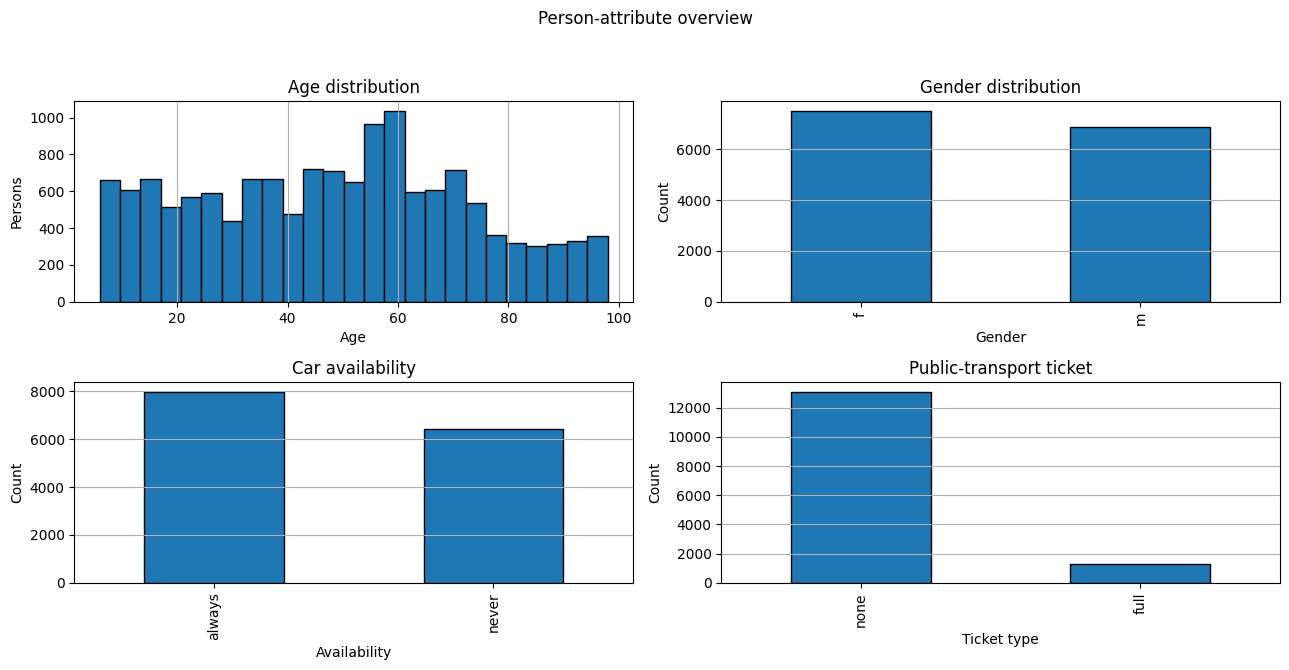

Total persons: 14386


In [3]:
# choose population file
local_population =  True

if local_population:
    population_file = "data/populationATA.xml.gz"
else:
    population_file = "data/populationSTA.xml.gz"

from matsim_helpers import list_activity_types

activity_types = list_activity_types(population_file)

from matsim_helpers import plot_person_attributes

wide_attr_df = plot_person_attributes("data/personAttributesATA.xml.gz", figsize=(13,7), age_bins=25)

### Zelle 3: Aktivitäts­ketten darstellen  
`plot_activity_chains()` zeichnet bis zu 1 000 zufällig ausgewählte Wegeketten („home ➜ … ➜ destination“) der Bevölkerung:  
- Schwarze Linien = Wege, blaue Punkte = Start („home“), rote Punkte = Ziel der Kette.  
- **Wichtige Parameter:**  
  - `n_chains`: Anzahl gezeichneter Personenketten. Weniger = schneller.  
  - `bbox`: Koordinaten­rahmen zum Eingrenzen des Kartenausschnitts.  
Damit erkennst du typische Pendlerwege und Hot-Spots im Gebiet.


Plotting chains:   0%|          | 0/1000 [00:00<?, ?it/s]

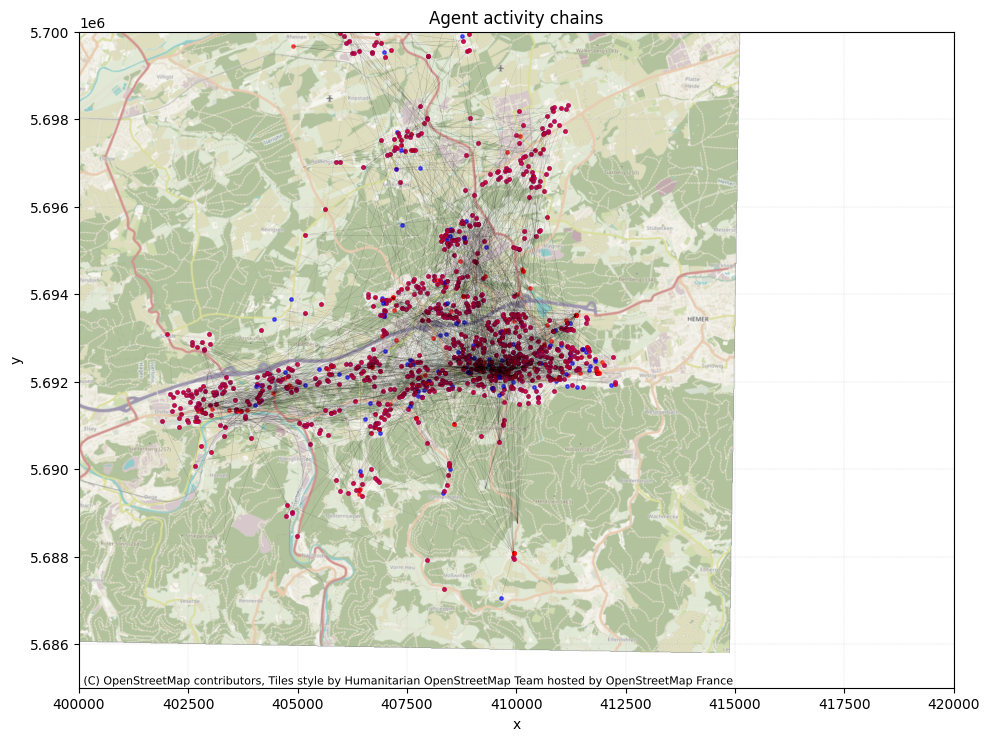

In [4]:
from matsim_helpers import plot_activity_chains

chains_subset = plot_activity_chains(
    population_file=population_file,
    n_chains=1000,
    figsize=(10, 10),
    bbox=(0.4e6, 5.685e6, 0.42e6, 5.70e6)
)

### Zelle 4: Konfiguration anpassen  
Hier stellst einige wichtige MATSim-Parameter ein und daraufhin wird eine neue `config_out.xml` automatisch geschrieben, welche dann von MATsim verwendet wird.

- **Häufig veränderte Werte:**  
  - `NUM_ITERATIONS`: Simulations­durchläufe (mehr = genauer, aber langsamer).  
  - `flowCapacityFactor` & `storageCapacityFactor`: < 1 → künstliche Verknappung, Stau tritt früher auf.  
  - `modeParams.<mode>.constant` & `traveling`: Nutzen-Werte einzelner Verkehrsmittel.  
- **Wie es funktioniert:** `update_config()` sucht die betreffenden XML-Einträge und überschreibt sie (oder legt sie an).  
Passe einfach das `updates{}`-Dict an deine Fragestellung an.


In [5]:
NUM_ITERATIONS = 10

updates = {
    # ───────── Controller / Global ───────────────────────────────────────
    "controller:lastIteration": NUM_ITERATIONS,  # F8 – Wie viele Iterationen braucht das Modell, bis es sich beruhigt?
    "global:numberOfThreads": 8,                 # rein technisch (Performance), keine inhaltliche Frage

    # ───────── Eingabedateien (hier nichts ändern) ──────────────────────
    "network:inputNetworkFile": "data/network.xml.gz",
    "plans:inputPlansFile": population_file,

    # ───────── QSim (Angebots-Seite) ─────────────────────────────────────
    "qsim:flowCapacityFactor": 0.25,   # F1 & F2 – Welche Links kollabieren zuerst, wenn wir die Kapazität drosseln?
    "qsim:storageCapacityFactor": 0.25,# F2 – Wo baut sich Rückstau auf, wenn Warteschlangen kürzer sein müssen?
    "qsim:mainMode": "car",            # F2 & F4 – Was passiert, wenn wir statt Auto den ÖV stauen lassen?
    "qsim:seepMode": "bike",           # F11 – Profitieren Radfahrende vom „Seepage“-Effekt bei Stau?

    # ───────── Replanning / Strategien ──────────────────────────────────
    "strategy:Module_3": "SubtourModeChoice",               # F4 & F11 – Modal Split dynamisch verändern
    "strategy:ModuleProbability_3": 0.1,                    # F8 – Lernrate: Wie schnell passen sich Agenten an?
    "strategy:fractionOfIterationsToDisableInnovation": 0.8,# F8 – Ab wann friert die Innovation ein?

    # ───────── SubtourModeChoice ────────────────────────────────────────
    "subtourModeChoice:modes": "car,pt,bike,walk",          # F11 – Welche Modi konkurrieren miteinander?
    "subtourModeChoice:chainBasedModes": "car,bike",        # F4 – Rundreise-Zwang: Fördert das Autonutzung?
    "subtourModeChoice:considerCarAvailability": "true",    # F4 – Führt Autobesitz zwangsläufig zu Autonutzung?

    # ───────── Scoring (verhaltens­ökonomische Kosten) ──────────────────
    "scoring:modeParams.car.marginalUtilityOfTraveling_util_hr": -8.0,  # F6 – Mehr „Stress“ im Auto ⇒ weniger Fahrten?
    "scoring:modeParams.car.monetaryDistanceRate": -0.01,               # F6 – Wirkung einer Kilometer-Maut?
    "scoring:modeParams.pt.marginalUtilityOfTraveling_util_hr": -4.0,   # F7 – Komfortsteigerung im ÖV?
    "scoring:modeParams.pt.monetaryDistanceRate": 0.0,                  # F7 – Tarifänderungen im ÖV
    "routing:teleportedModeParameters.walk.teleportedModeSpeed": 1.2,   # F10 – „15-Minuten-Stadt“ vs. Gehgeschwindigkeit

    # ───────── Öffentlicher Verkehr ─────────────────────────────────────
    "transit:useTransit": "false",                  # F7 – Was passiert ohne ÖV-Angebot?
    "transit:vehiclesFile": "data/transitVehicles.xml.gz",
    "transit:transitScheduleFile": "data/transitSchedule.xml.gz",

    # ───────── Travel-Time Calculator ───────────────────────────────────
    "travelTimeCalculator:travelTimeBinSize": 600.0,  # F9 – Feinere Zeit­scheiben helfen, den Wendepunkt zu finden

    # ───────── Output-Häufigkeit ────────────────────────────────────────
    "controller:writeEventsInterval": 10,   # nur I/O-Detail
    "controller:writeTripsInterval": 10,    # nur I/O-Detail
    "linkStats:writeLinkStatsInterval": 1,  # F1–F3 – Link-Statistiken jeder Iteration für Flow-/Stau-Karten

    # ───────── Counts-Scaling (optional) ────────────────────────────────
    # "counts:countsScaleFactor": 10.0,     # Validierungsfrage: Wie skaliert man Zähldaten bei Stichproben?
}


from matsim_helpers import update_config

update_config("config_base.xml", updates, "config_out.xml")

✅ controller:lastIteration = 10
✅ global:numberOfThreads = 8
✅ network:inputNetworkFile = data/network.xml.gz
✅ plans:inputPlansFile = data/populationATA.xml.gz
✅ qsim:flowCapacityFactor = 0.25
✅ qsim:storageCapacityFactor = 0.25
✅ qsim:mainMode = car
✅ qsim:seepMode = bike
✅ strategy:Module_3 = SubtourModeChoice
✅ strategy:ModuleProbability_3 = 0.1
✅ strategy:fractionOfIterationsToDisableInnovation = 0.8
✅ subtourModeChoice:modes = car,pt,bike,walk
✅ subtourModeChoice:chainBasedModes = car,bike
✅ subtourModeChoice:considerCarAvailability = true
✅ scoring:modeParams.car.marginalUtilityOfTraveling_util_hr = -8.0
✅ scoring:modeParams.car.monetaryDistanceRate = -0.01
✅ scoring:modeParams.pt.marginalUtilityOfTraveling_util_hr = -4.0
✅ scoring:modeParams.pt.monetaryDistanceRate = 0.0
✅ routing:teleportedModeParameters.walk.teleportedModeSpeed = 1.2
✅ transit:useTransit = false
✅ transit:vehiclesFile = data/transitVehicles.xml.gz
✅ transit:transitScheduleFile = data/transitSchedule.xml.gz
✅ 

### Zelle 5: Simulation starten  
`run_matsim()` startet die Simulation, und leert vorher den alten `output/`-Ordner um Platz für die neuen Ergebnisse zu machen. Je nach Konfiguration der Parameter kann das ausführen zwischen 5 und 15 Minuten dauern.

In [6]:
from matsim_helpers import run_matsim

run_matsim()

Running MATSim ...
MATSim run complete.


### Zelle 6: Flusskarten erzeugen  
`link_flow_maps()` malt für jede Zeitspanne (hier: 6 zweistündige Bins) das Verkehrs­aufkommen pro Straßensegment.  
- Dickere & dunklere Linien = mehr Fahrzeuge.  
- **Parameter:**  
  - `bins`: Anzahl der Plots in der Tag unterteilt werden soll.
  - `stat`: `"avg"` = Durchschnitt pro Iteration, `"min"`/`"max"` ebenfalls möglich.  
  - `bbox`: Kartenausschnitt begrenzen, um Details besser zu sehen.

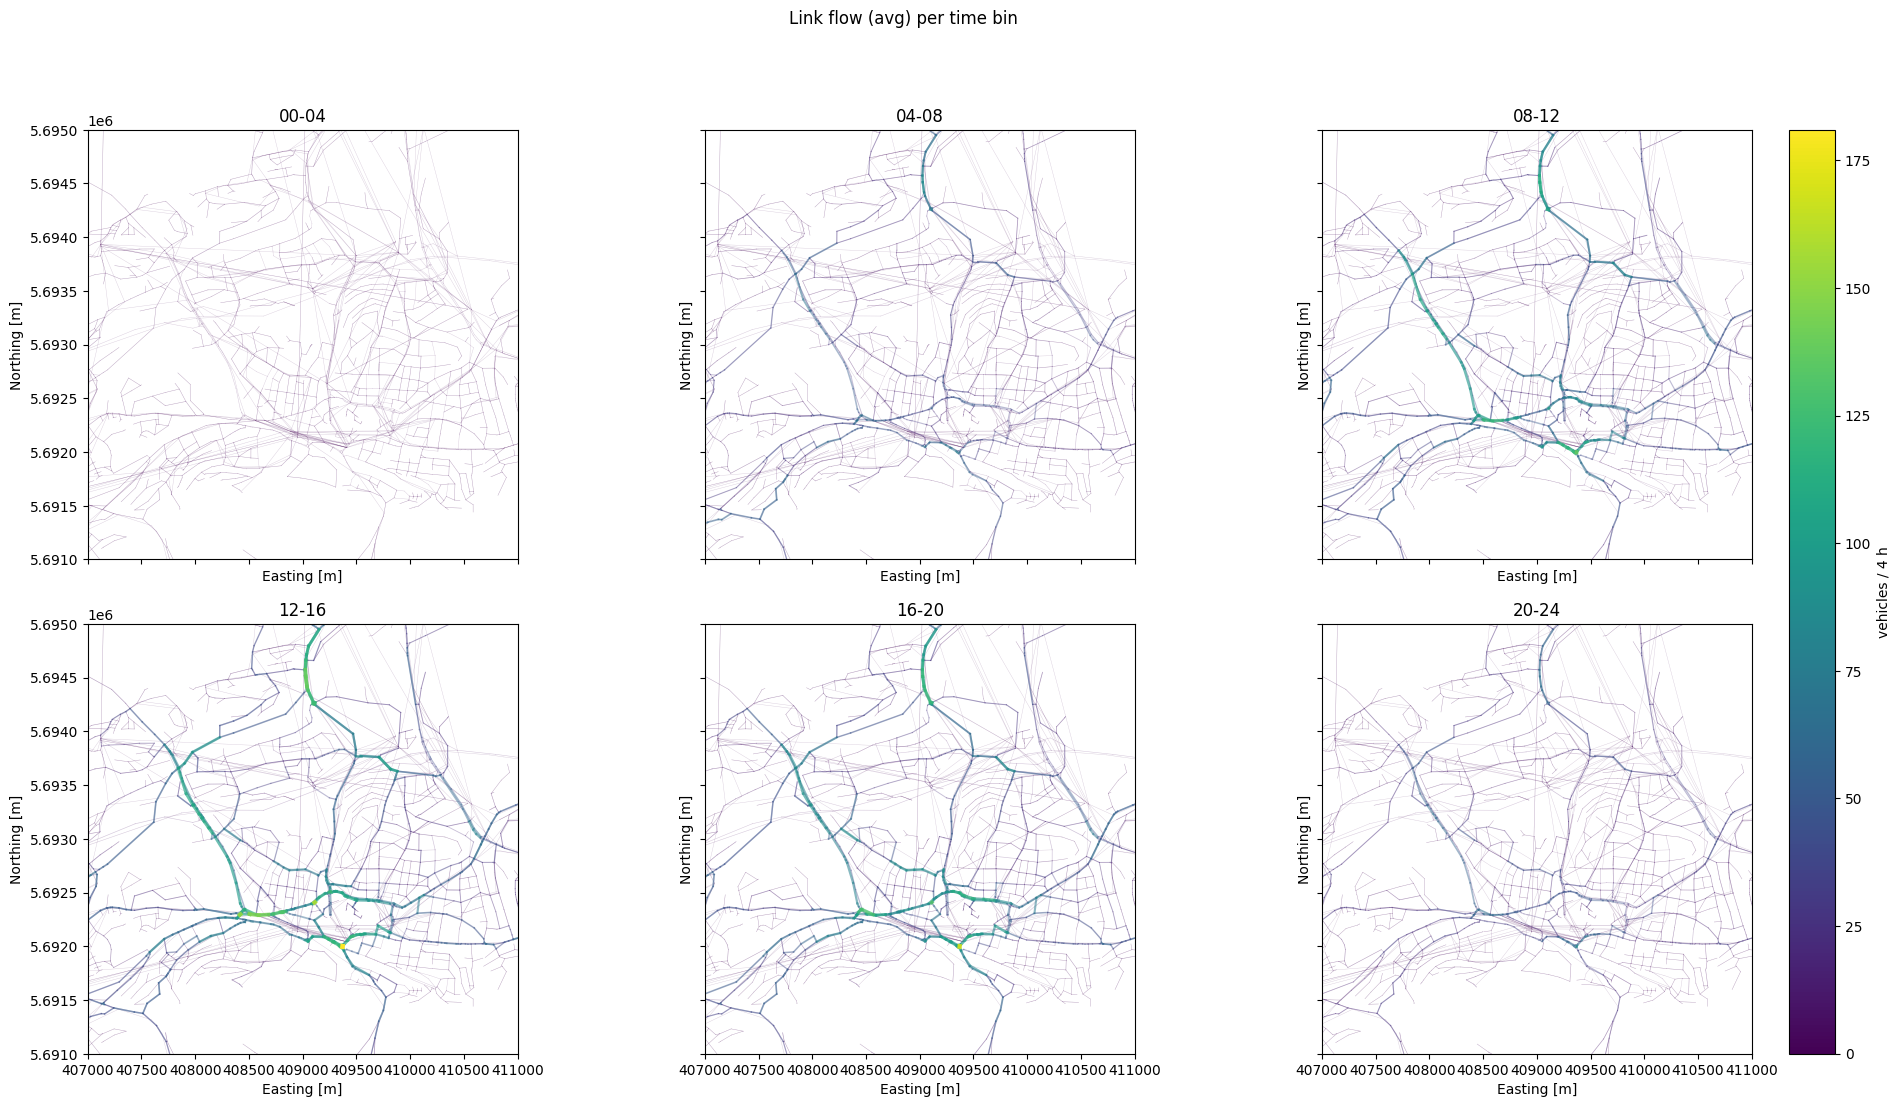

In [7]:
from matsim_helpers import link_flow_maps
link_flow_maps(f'output/ITERS/it.{NUM_ITERATIONS}/{NUM_ITERATIONS}.linkstats.txt.gz', 'output/output_network.xml.gz', bins=6, stat='avg', bbox=(0.407e6, 5.691e6, 0.411e6, 5.695e6))

### Zelle 7: Stau-/Geschwindigkeitskarten  
`link_congestion_maps()` vergleicht gefahrene Geschwindigkeit mit Freifahrtgeschwindigkeit:  
- Grün = flüssig, Rot = stark verstopft.  
- Linien werden dicker, je stärker der Stau.  
- Die Bins-Logik entspricht der vorherigen Zelle - passe sie identisch an, um beide Karten vergleichen zu können.

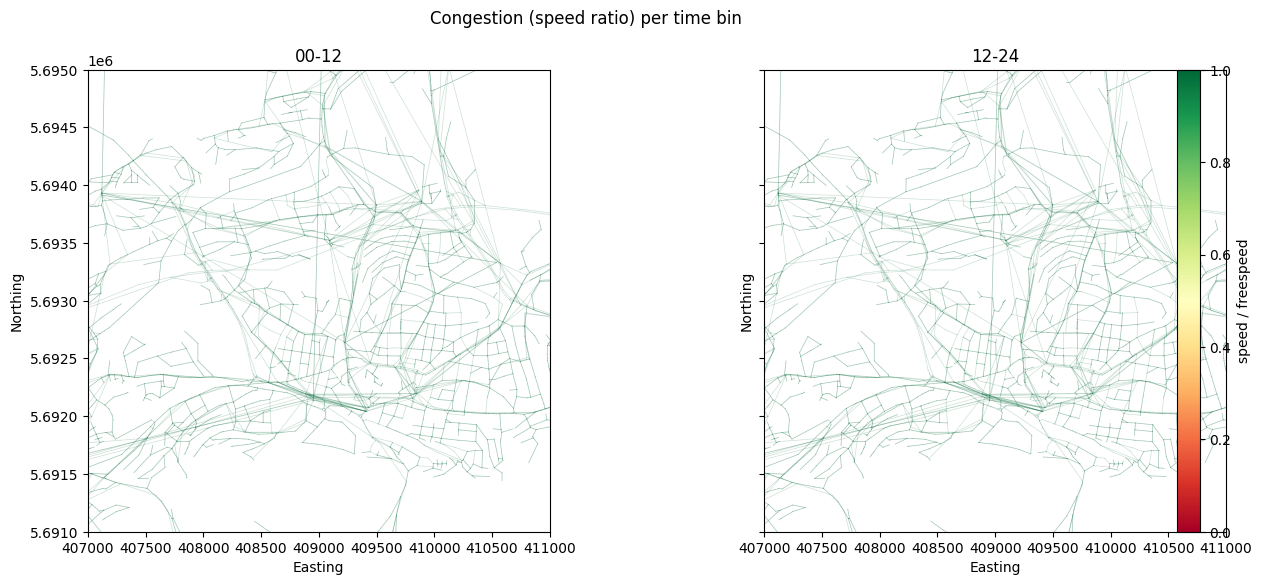

In [8]:
from matsim_helpers import link_congestion_maps

link_congestion_maps(
    f'output/ITERS/it.{NUM_ITERATIONS}/{NUM_ITERATIONS}.linkstats.txt.gz',
    'output/output_network.xml.gz',
    bins=2,
    bbox=(0.407e6, 5.691e6, 0.411e6, 5.695e6))


### Zelle 8: Modal-Split-Entwicklung  
`plot_mode_share()` zeigt erst einen gestapelten Flächenverlauf über alle Iterationen und danach den Modal-Split der letzten Iteration als Balken.  
- Funktioniert mit breiten (`car,pt,bike,…`) **oder** langen (`mode,share`) CSVs.  
- Kommentare in Prozent vs. absoluter Zahl erkennt die Funktion selbst.


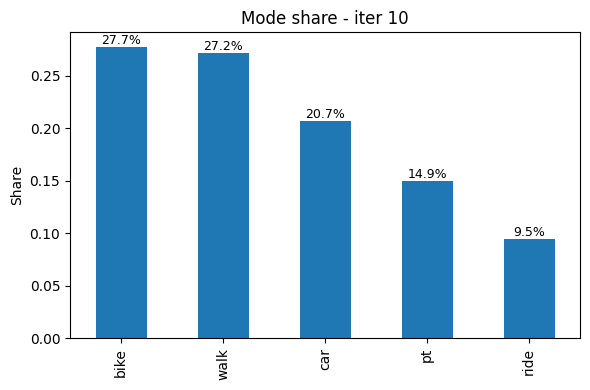

In [9]:
from matsim_helpers import plot_mode_share

plot_mode_share('output/modestats.csv')

### Zelle 9: Entfernung nach Verkehrsmittel  
`hist_dist_by_mode()` öffnet die `trips.csv(.gz)` und erzeugt **eine Abbildung pro Verkehrsmittel**, Balken gefärbt nach Ziel-Aktivität (Arbeit, Einkaufen …).  
- Große Datenmengen? Verringere `bins` oder filtere das CSV vorab.  
- Jede Legende zeigt den Medianwert - praktisch, um typische Reichweiten zu vergleichen.

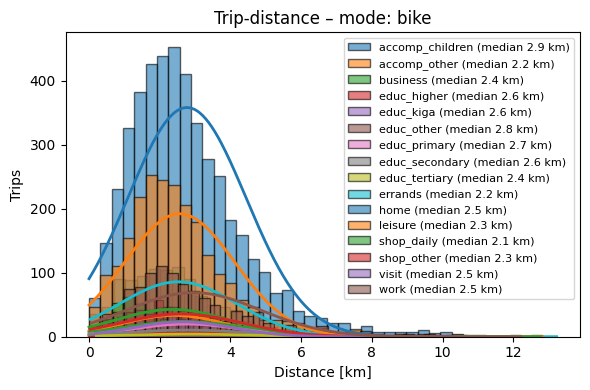

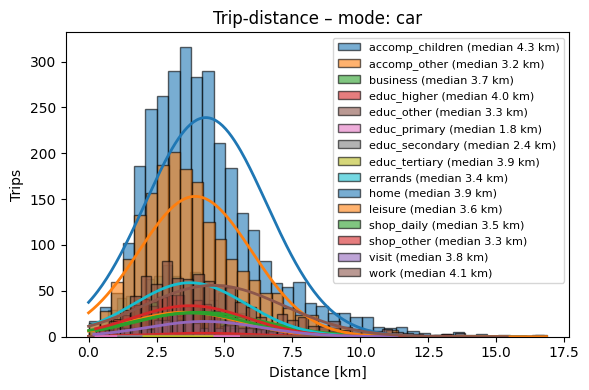

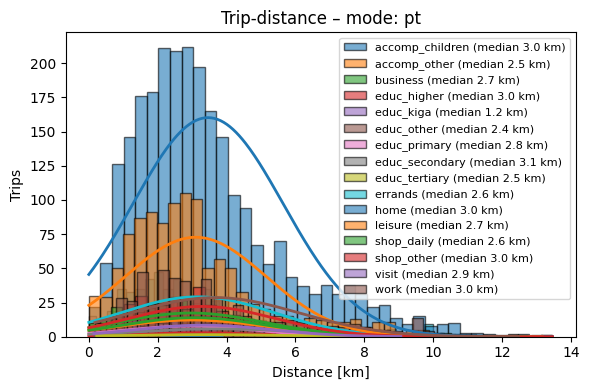

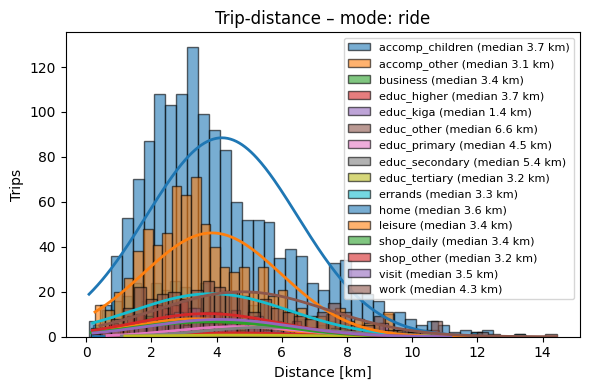

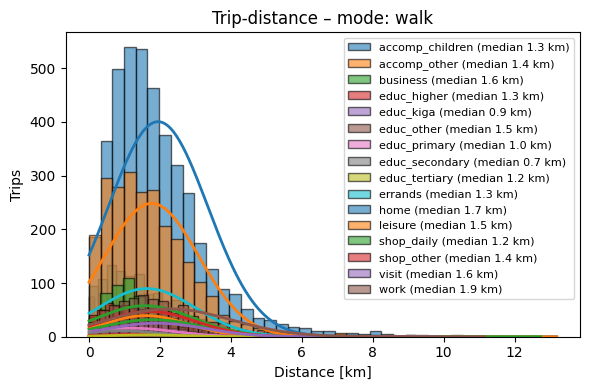

In [10]:
from matsim_helpers import hist_dist_by_mode
# one plot per mode, coloured by activity (legend shows median km)
hist_dist_by_mode('output/output_trips.csv.gz', bins=40)

### Zelle 10: Entfernung nach Aktivität  
`hist_dist_by_activity()` ist das Gegenstück: **eine Abbildung pro Aktivität**, Balken gefärbt nach Hauptverkehrsmittel.  
- Nutze beide Histogramm-Typen, um z. B. zu sehen, ob Einkaufsfahrten häufiger per Fahrrad gemacht werden oder wie lang Schulwege typischerweise sind.

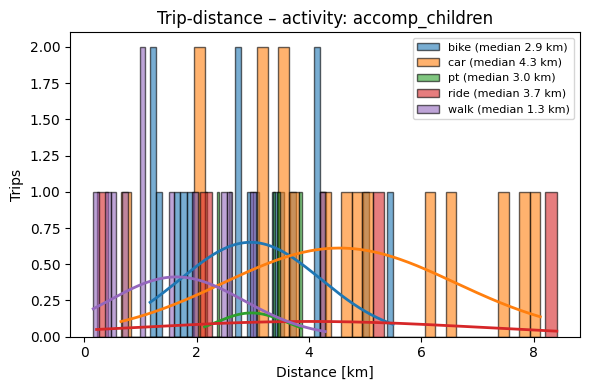

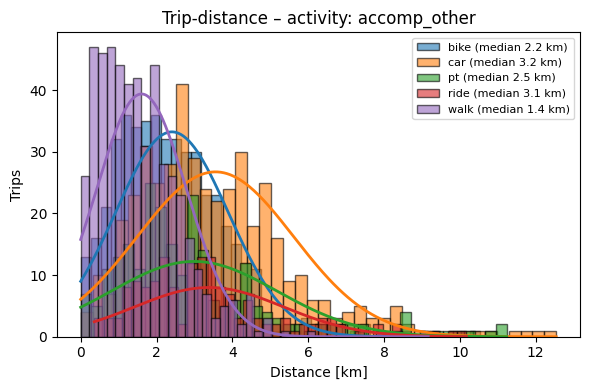

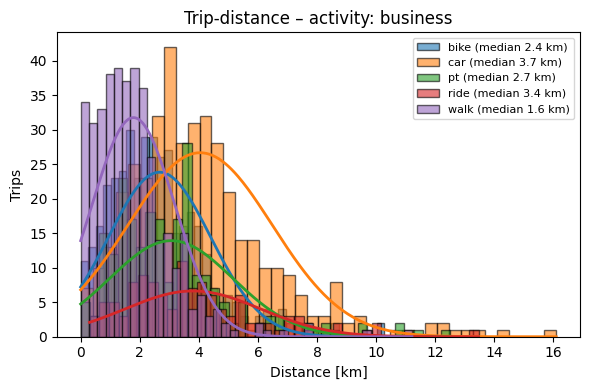

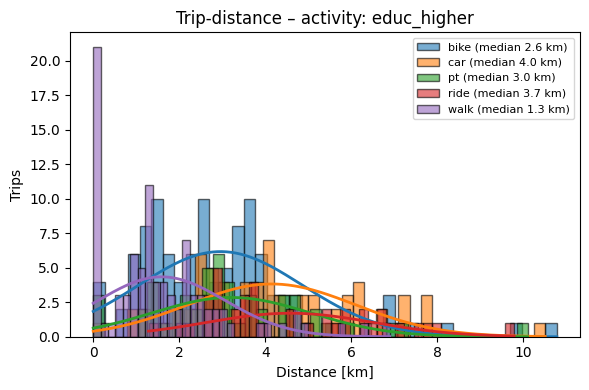

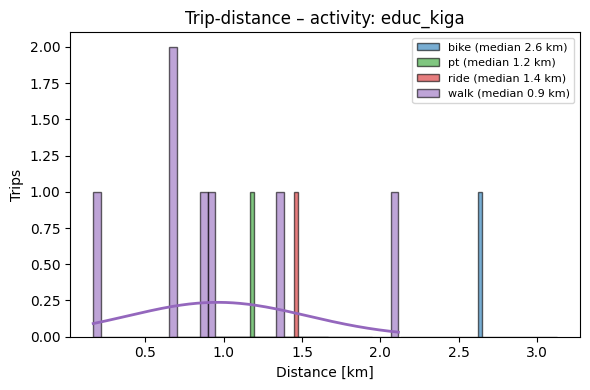

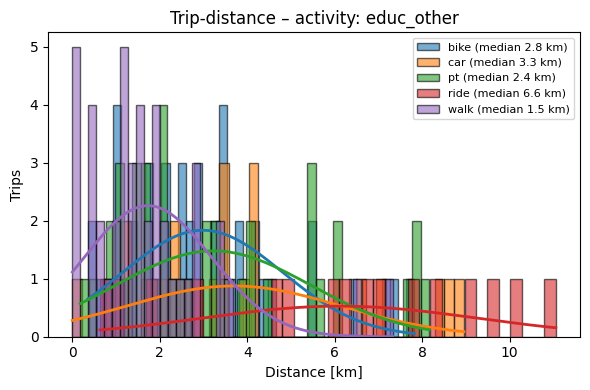

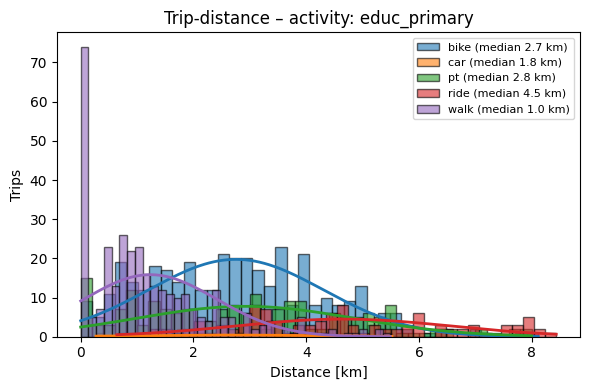

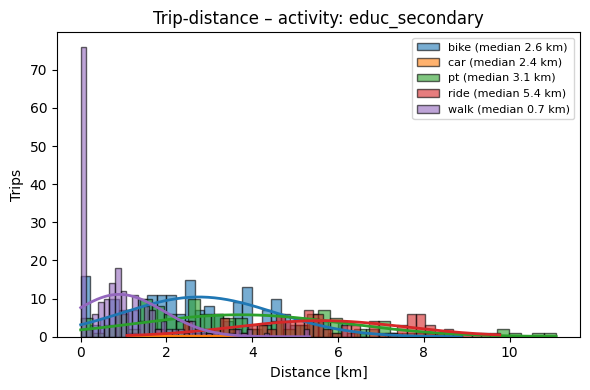

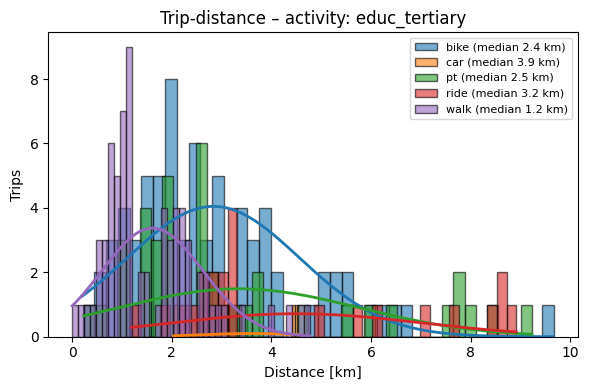

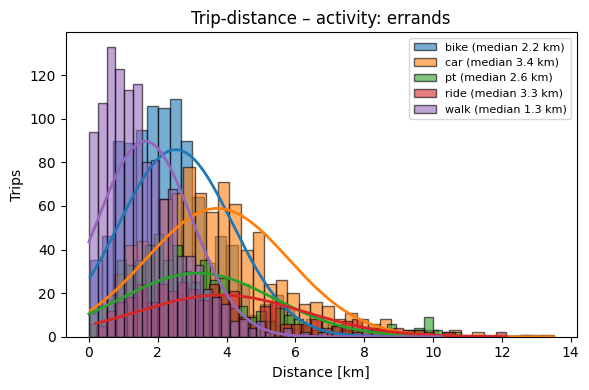

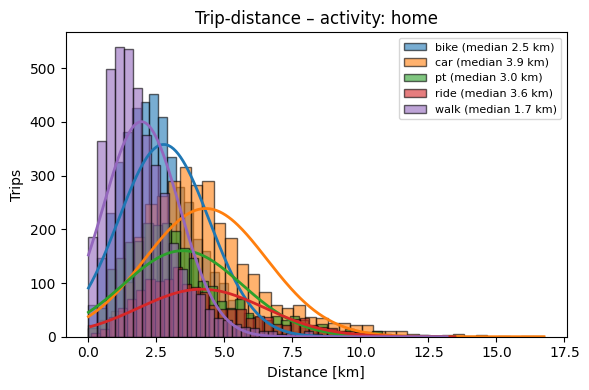

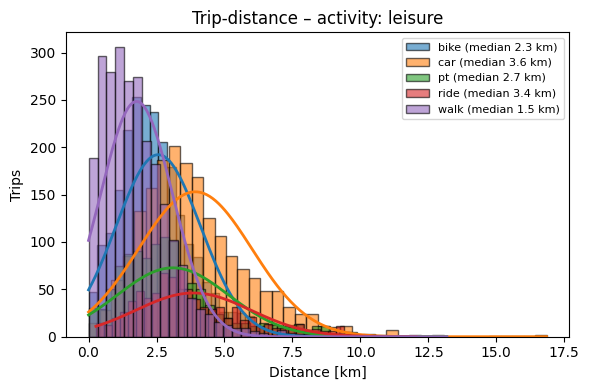

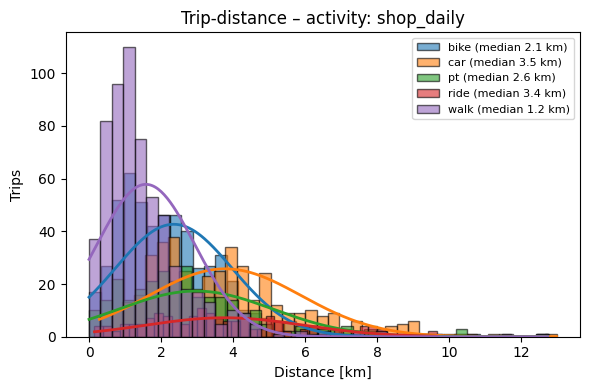

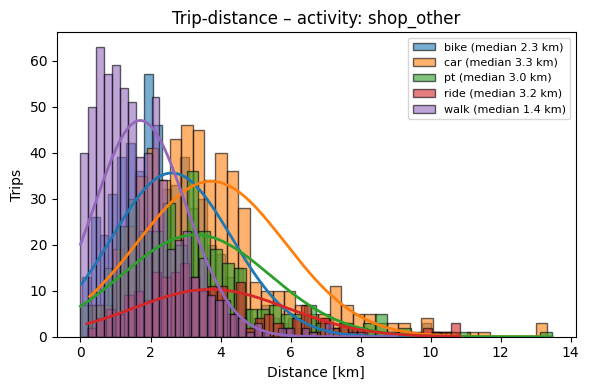

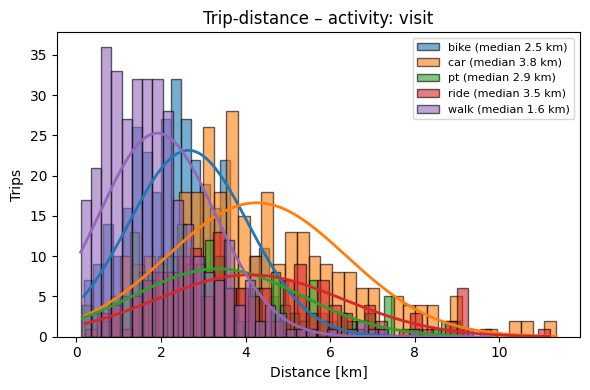

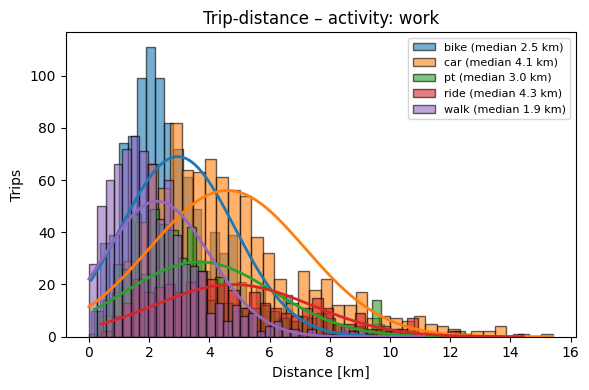

In [11]:
from matsim_helpers import hist_dist_by_activity
# one plot per activity type, coloured by mode (legend shows median km)
hist_dist_by_activity('output/output_trips.csv.gz', bins=40)